In [43]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"]=(20,10)
import seaborn as sns

In [44]:
df = pd.read_csv('data.csv')

In [45]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [46]:
df.head()

,location,bedrooms,bath,size,price
0,"MotijheelExtension,Motijheel,Dhaka",3.0,2.0,1750,9500000
1,"MotijheelExtension,Motijheel,Dhaka",3.0,2.0,1615,9500000
2,"MotijheelExtension,Motijheel,Dhaka",3.0,2.0,1615,9500000
3,"Sector5,Uttara,Dhaka",2.0,2.0,807,5200000
4,"BlockG,BashundharaR-A,Dhaka",4.0,4.0,3100,40000000


# Data Cleaning

In [47]:
df.isnull().sum()

location      0
bedrooms    311
bath        311
size          0
price         0
dtype: int64

In [48]:
df = df.fillna(3)

In [49]:
df.isnull().sum()

location    0
bedrooms    0
bath        0
size        0
price       0
dtype: int64

In [50]:
df['location'] = df['location'].str.lower()

In [51]:
df['location'] = df['location'].str.split(',',n=0,expand=True)

In [52]:
df.head()

,location,bedrooms,bath,size,price
0,motijheelextension,3.0,2.0,1750,9500000
1,motijheelextension,3.0,2.0,1615,9500000
2,motijheelextension,3.0,2.0,1615,9500000
3,sector5,2.0,2.0,807,5200000
4,blockg,4.0,4.0,3100,40000000


In [53]:
df.shape

(8720, 5)

<AxesSubplot:>

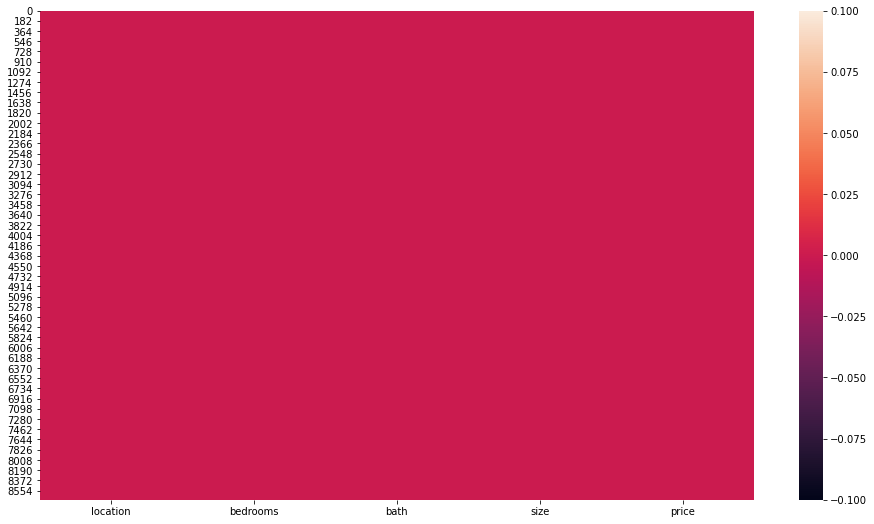

In [54]:
plt.figure(figsize=(16,9))
sns.heatmap(df.isnull())

In [55]:
df2 = df.drop_duplicates()

In [56]:
df2.shape
df2.dtypes

location     object
bedrooms    float64
bath        float64
size          int64
price         int64
dtype: object

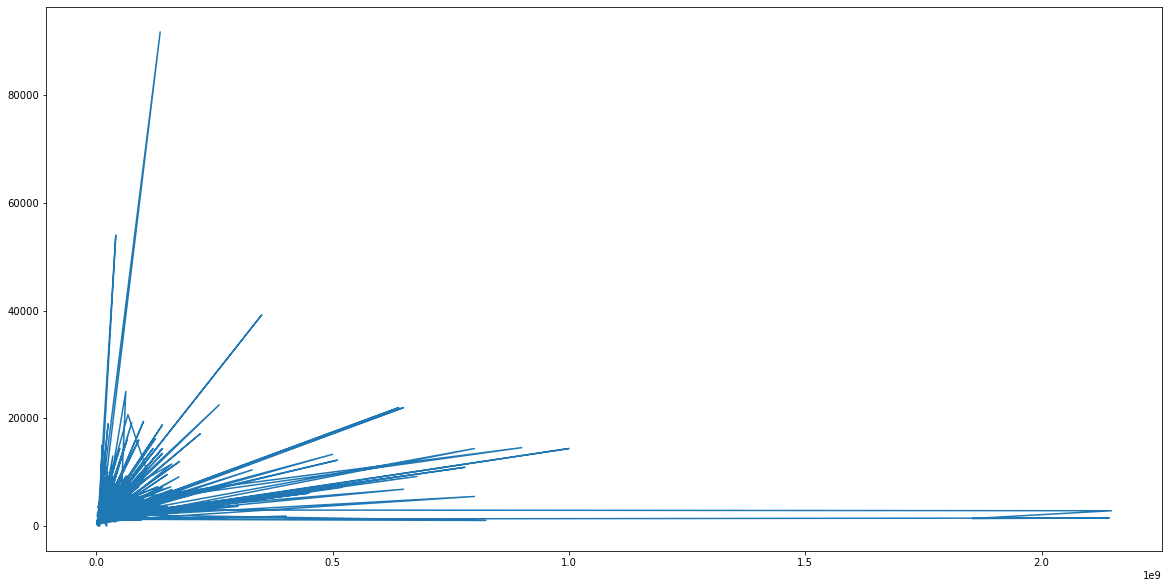

In [57]:
plt.plot(df2['price'],df2['size'])
plt.show()

In [65]:
bed20=df2[df2['bedrooms']>20.0]
i = bed20.index


In [68]:
df2 = df2.drop(i)



In [ ]:
df3 = df2[df2['bedrooms']<20.0]
df3 = df2[df2['bath']<20.0]
df3 = df2[df2['size']<7000.0]
df3 = df2[df2['price']<30000000.0]
df3.shape

In [ ]:
plt.plot(df3['size'],df3['price'])
plt.show()

In [ ]:
sns.pairplot(df3)

In [25]:
df2['bedrooms'].sort_values()


KeyError: 'bedrooms'

In [ ]:
df3.describe()

In [ ]:
location_stats = df3.groupby('location')['location'].agg('count').sort_values(ascending=False)
location_stats.head()

In [ ]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10.head()

In [ ]:
df3.location=df3.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(df3.location.unique())

In [ ]:
dummies = pd.get_dummies(df3.location)
dummies.head()

In [ ]:
df4 = pd.concat([df3,dummies.drop('other',axis='columns')],axis='columns')

In [ ]:
df4 = df4.drop('location',axis='columns')

In [ ]:
df4.head()

In [ ]:
X = df4.drop(['price'],axis='columns')
X.head(3)

In [ ]:
y = df4.price
y.head(3)

# Model

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

NameError: name 'X' is not defined

In [ ]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
lr_clf.score(X_test,y_test)

In [ ]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

In [ ]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,y)

In [ ]:
def predict_price(location,sqft,bath,bhk):    
    loc_index = np.where(X.columns==location)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1

    return lr_clf.predict([x])[0]

In [ ]:
predict_price('sector10',2000, 2, 2)